In [249]:
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

class card_tag:
    def __init__(self, cost = None, land = False, fetch = False, surveil = False, fetch_cost = None, land_type = None, can_fetch = None, protection = False, untapped = True, sac_target = False, sac_outlet = False, produces_green = False, produces_blue = False, green = False, pitch_cost = None, cantrip = False, effective_cantrip_strength = None,):
        self.cost = cost
        self.land = land
        self.fetch = fetch
        self.surveil = surveil
        self.fetch_cost = fetch_cost
        self.land_type = land_type
        self.can_fetch = can_fetch
        self.untapped = untapped
        self.protection = protection
        self.sac_target = sac_target
        self.sac_outlet = sac_outlet
        self.produces_green = produces_green
        self.produces_blue = produces_blue
        self.green = green
        self.pitch_cost = pitch_cost

CARD_TAGS = {
    "Allosaurus Rider" : card_tag(sac_target=True, green=True, pitch_cost="GG"),
    "Atraxa, Grand Unifier" : card_tag(green=True),
    "Boseiju, Who Endures" : card_tag(land=True, produces_green=True),
    "Breeding Pool" : card_tag(land=True, produces_green=True, produces_blue=True, land_type=["Forest", "Island"]),
    "Bridgeworks Battle" : card_tag(land=True, green=True, produces_green=True),
    "Consign to Memory" : card_tag(),
    "Disciple of Freyalise" : card_tag(land=True, green=True, produces_green=True),
    "Eldritch Evolution": card_tag(cost = "GGC", sac_outlet=True, green=True,),
    "Endurance": card_tag(green=True),
    "Flooded Strand": card_tag(land=True, fetch=True, can_fetch=['Island', 'Plain']),
    "Forest": card_tag(land=True, land_type=["Forest"], produces_green=True),
    "Generous Ent": card_tag(green=True, fetch=True, can_fetch=["Forest"], fetch_cost=1),
    "Ghalta, Stampede Tyrant": card_tag(green=True,),
    "Griselbrand": card_tag(),
    "Hedge Maze": card_tag(land=True, untapped=False, produces_green=True, produces_blue=True, land_type=['Island', "Forest"], surveil=True,),
    "Hooting Mandrills": card_tag(green=True), # for now I'll ignore mandrills, I'll implement delve later
    "Island" : card_tag(land=True, land_type=['Island'], produces_green=True),
    "Misty Rainforest": card_tag(land=True, fetch=True, can_fetch=['Island', 'Forest']),
    "Neoform": card_tag(cost = "UG", sac_outlet=True, green=True,),
    "Pact of Negation" : card_tag(protection=True),
    "Planar Genesis": card_tag(cost = "UG", green=True, cantrip=True, effective_cantrip_strength=4),
    "Preordain": card_tag(cost = "U", cantrip=True, effective_cantrip_strength=3),
    "Scalding Tarn": card_tag(land=True, fetch=True, can_fetch=['Island', 'Mountain']),
    "Summoner's Pact": card_tag(sac_target=True, green=True, pitch_cost="GG"), # for now we'll just consider pact as additional copies of Rider
    "Veil of Summer": card_tag(cost = "G", green=True, protection=True),
    "Xenagos, God of Revels": card_tag(green=True)
}

In [250]:
def get_starting_hand(deck):
    return deck[:7]

def initialize_deck(deck_list):
    deck = []

    for key, value in deck_list.items():
        deck.extend([key]*value)

    random.shuffle(deck)
    deck_card_tags = [CARD_TAGS[card] for card in deck]

    full_deck = [(name, tags) for name, tags in zip(deck, deck_card_tags)]

    return full_deck

def draw(deck, n):
    drawn_cards = []
    for i in range(n):
        drawn_cards.append(deck.pop(0))

    return drawn_cards

def get_card_names(card_list):
    return [card[0] for card in card_list]

def get_missing_mana(card, mana_production = []):
    temp_mana_production = mana_production.copy()
    cost = card[1].cost
    missing_mana = []
    for pip in cost:
        if pip != "C":
            # for colored mana, check if we have a land that only produces that mana and tap it, if not, tap a dual
            candidates = [i for i, src in enumerate(temp_mana_production) if src == [pip]]
            if len(candidates) > 0:
                temp_mana_production.pop(candidates[0])
            else:
                candidates = [i for i, src in enumerate(temp_mana_production) if pip in src]
                if len(candidates) > 0:
                    temp_mana_production.pop(candidates[0])
                else:
                    missing_mana.append(pip)
        else:
            # for generic mana, tap the land of the color we have the most of, if equal, tap green (?)
            candidates = [i for i, src in enumerate(temp_mana_production) if len(src) == 1]
            if len(candidates) > 0:
                green_singles = np.sum(np.array(candidates) == ['G'])
                blue_singles = np.sum(np.array(candidates) == ['U'])

                if green_singles >= blue_singles:
                    candidates = [i for i, src in enumerate(temp_mana_production) if src == ['G']]
                    temp_mana_production.pop(candidates[0])
                else:
                    candidates = [i for i, src in enumerate(temp_mana_production) if src == ['U']]
                    temp_mana_production.pop(candidates[0])
            else:
                candidates = [i for i, src in enumerate(temp_mana_production) if len(src) > 0] # we cannot tap fetch lands for mana
                if len(candidates) > 0:
                    temp_mana_production.pop(candidates[0])
                else:
                    missing_mana.append(pip)

    return missing_mana

def get_mana_production_of_land(land):
    tags = land[1]
    if tags.land_type:
        return len(tags.land_type)
    else:
        return 1 

def fetch(fetch_land, deck, missing_combo_pieces, missing_mana, missing_green_cards):
    if missing_combo_pieces or missing_green_cards:
        surveil_lands_in_deck = [card for card in deck if card[1].surveil]
        if surveil_lands_in_deck:
            fetched_land = surveil_lands_in_deck[0]
        else:
            fetchable_types = fetch_land[1].can_fetch
            lands_with_types = [card for card in deck if card[1].land_type]
            fetchable_lands = [card for card in lands_with_types if np.any([land_type in fetchable_types for land_type in card[1].land_type])]
            fetchable_lands = sorted(fetchable_lands, key = lambda x: len(x[1].land_type), reverse=True)
            if fetchable_lands:
                fetched_land = fetchable_lands[0]
            else:
                fetched_land = fetch_land
    elif missing_mana == 1:
        fetchable_types = fetch_land[1].can_fetch
        lands_with_types = [card for card in deck if card[1].land_type]
        fetchable_lands = [card for card in lands_with_types if np.any([land_type in fetchable_types for land_type in card[1].land_type])]
        fetchable_lands = sorted(fetchable_lands, key = lambda x: len(x[1].land_type), reverse=True)
        if fetchable_lands:
                fetched_land = fetchable_lands[0]
        else:
            fetched_land = fetch_land

    else:
        surveil_lands_in_deck = [card for card in deck if card[1].surveil]
        if surveil_lands_in_deck:
            fetched_land = surveil_lands_in_deck[0]
        else:
            fetchable_types = fetch_land[1].can_fetch
            lands_with_types = [card for card in deck if card[1].land_type]
            fetchable_lands = [card for card in lands_with_types if np.any([land_type in fetchable_types for land_type in card[1].land_type])]
            fetchable_lands = sorted(fetchable_lands, key = lambda x: len(x[1].land_type), reverse=True)
            if fetchable_lands:
                fetched_land = fetchable_lands[0]
            else:
                fetched_land = fetch_land

    random.shuffle(deck)
    return fetched_land

def surveil(deck, missing_sac_target, missing_sac_outlet, missing_mana, missing_green_cards):
    card_on_top = deck[0]
    if missing_sac_outlet and card_on_top[1].sac_outlet:
        pass
    elif missing_sac_target and card_on_top[1].sac_target:
            pass
    elif missing_mana > 0 and card_on_top[1].land:
        pass
    elif missing_green_cards and card_on_top[1].green:
        pass
    else:
        deck.pop(0)

def check_if_castable(card, mana_production=[]):
    missing_mana = get_missing_mana(card, mana_production)
    return len(missing_mana) == 0

def simulate_game_on_play_no_mull(deck_list, turns_to_win = 50):
    deck = initialize_deck(deck_list)
    hand = draw(deck, n=7)  # draw() returns a list of tuples, so hand is a list of tuples
    battlefield = []
    mana_production = []

    for turn in range(1, turns_to_win+1):
        if turn != 1:
            # draw a card and extend the hand (don't append the list)
            drawn = draw(deck, 1)
            if drawn:
                hand.extend(drawn)

        mana_production_for_turn = mana_production # untap phase
        land_drop_left = True

        # try to win
        sac_targets = [card for card in hand if card[1].sac_target]
        sac_outlets = [card for card in hand if card[1].sac_outlet]
        green_cards = [card for card in hand if card[1].green]
        sac_outlet_castable = np.any([check_if_castable(sac_outlet, mana_production_for_turn) for sac_outlet in sac_outlets])
        sac_target_castable = (len(sac_targets) >= 0) & (len(green_cards) >= 4) # you need to take the rider and the sac outlet into account
        win = sac_outlet_castable & sac_target_castable
        if win:
            return turn
        
        lands_in_hand = [card for card in hand if card[1].land]
        missing_mana_to_cast_sac_outlet = [get_missing_mana(sac_outlet, mana_production_for_turn) for sac_outlet in sac_outlets]
        missing_mana = np.min([len(c) for c in missing_mana_to_cast_sac_outlet]) if len(missing_mana_to_cast_sac_outlet) != 0 else (2 - len(mana_production)) # you should also take into account how many lands we have in hand
        missing_sac_target = (len(sac_targets) == 0)
        missing_sac_outlet = (len(sac_outlets) == 0)
        missing_combo_pieces = missing_sac_target or missing_sac_outlet
        missing_green_cards = len(green_cards) < 4
        

        # play a land if possible
        if lands_in_hand:
            land_drop_left = False
            # priority for playing lands should be fetch -> surveil if missing combo pieces -> duals -> the right land to fix our mana
            fetch_lands_in_hand = [land for land in lands_in_hand if land[1].fetch]
            surveil_lands_in_hand = [land for land in lands_in_hand if land[1].surveil]
            untapped_lands_in_hand = [land for land in lands_in_hand if land[1].untapped]
            if len(untapped_lands_in_hand) > 1:
                untapped_lands_in_hand = sorted(untapped_lands_in_hand, key = get_mana_production_of_land, reverse=True)

            if len(fetch_lands_in_hand) > 0:
                land = fetch_lands_in_hand[0]
            elif (len(untapped_lands_in_hand) > 0) and missing_mana == 1:
                land = untapped_lands_in_hand[0]
            elif len(surveil_lands_in_hand) > 0:
                land = surveil_lands_in_hand[0]
            else:
                land = untapped_lands_in_hand[0]

            hand.remove(land)

            if land[1].fetch:
                fetched_land = fetch(land, deck, missing_combo_pieces, missing_mana, missing_green_cards)
                battlefield.append(fetched_land)
            else:
                battlefield.append(land)

            if getattr(battlefield[-1][1], "surveil", False):
                surveil(deck, missing_sac_target, missing_sac_outlet, missing_mana, missing_green_cards)

            land_production = []
            if getattr(battlefield[-1][1], "produces_green", False):
                land_production.append('G')
            if getattr(battlefield[-1][1], "produces_blue", False):
                land_production.append('U')
            if getattr(battlefield[-1][1], "untapped", False):
                mana_production_for_turn.append(mana_production)
            mana_production.append(land_production)
            
        # try to win again
        sac_targets = [card for card in hand if card[1].sac_target]
        sac_outlets = [card for card in hand if card[1].sac_outlet]
        green_cards = [card for card in hand if card[1].green]
        sac_outlet_castable = np.any([check_if_castable(sac_outlet, mana_production_for_turn) for sac_outlet in sac_outlets])
        sac_target_castable = (len(sac_targets) >= 0) & (len(green_cards) >= 4) # you need to take the rider and the sac outlet into account
        win = sac_outlet_castable & sac_target_castable
        if win:
            return turn
        
        # try to cast a cantrip

        # try to play a land again

    return None


This list wins on average on turn : 4.25104, median : 3.0


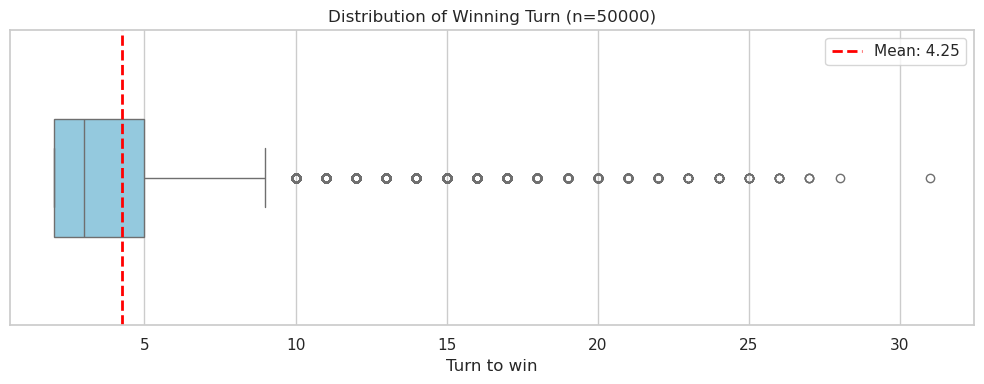

Wins on turn 2: 18328/50000 -> 36.66% of all games


In [251]:
deck_list = {
    "Allosaurus Rider" : 4,
    "Atraxa, Grand Unifier" : 1,
    "Boseiju, Who Endures" : 1,
    "Breeding Pool" : 1,
    "Bridgeworks Battle" : 2,
    "Consign to Memory" : 4,
    "Disciple of Freyalise" : 2,
    "Eldritch Evolution": 4,
    "Endurance": 1,
    "Flooded Strand": 2,
    "Forest": 1,
    "Generous Ent": 2,
    "Ghalta, Stampede Tyrant": 2,
    "Griselbrand": 1,
    "Hedge Maze": 3,
    "Hooting Mandrills": 1, # for now I'll ignore mandrills, I'll implement delve later
    "Island" : 1,
    "Misty Rainforest": 4,
    "Neoform": 4,
    "Pact of Negation" : 4,
    "Planar Genesis": 4,
    "Preordain": 0,
    "Scalding Tarn": 2,
    "Summoner's Pact": 4, # for now we'll just consider pact as additional copies of Rider
    "Veil of Summer": 4,
    "Xenagos, God of Revels": 1
}

win = []
for i in range(50000):
    w = simulate_game_on_play_no_mull(deck_list)
    win.append(w)

win = np.array(win, dtype=float)
average_turn_win = np.mean(win)
median_turn_win = np.median(win)

print(f'This list wins on average on turn : {average_turn_win}, median : {median_turn_win}')

# clean NaNs (games that didn't win)
wins_clean = win[~np.isnan(win)]

plt.figure(figsize=(10, 4))
ax = sns.boxplot(x=wins_clean, color="skyblue", width=0.4)

ax.set_xlabel("Turn to win")
ax.set_title(f"Distribution of Winning Turn (n={len(wins_clean)})")

# annotate mean and median
ax.axvline(average_turn_win, color="red", linestyle="--", linewidth=2, label=f"Mean: {average_turn_win:.2f}")
# ax.axvline(median_turn_win, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_turn_win:.0f}")

ax.legend()
plt.tight_layout()
plt.show()

count_turn2 = int(np.sum(win == 2))
pct_of_all = count_turn2 / win.size * 100
pct_of_wins = count_turn2 / wins_clean.size * 100 if wins_clean.size > 0 else np.nan

print(f"Wins on turn 2: {count_turn2}/{win.size} -> {pct_of_all:.2f}% of all games")

This list wins on average on turn : 4.5602, median : 3.0


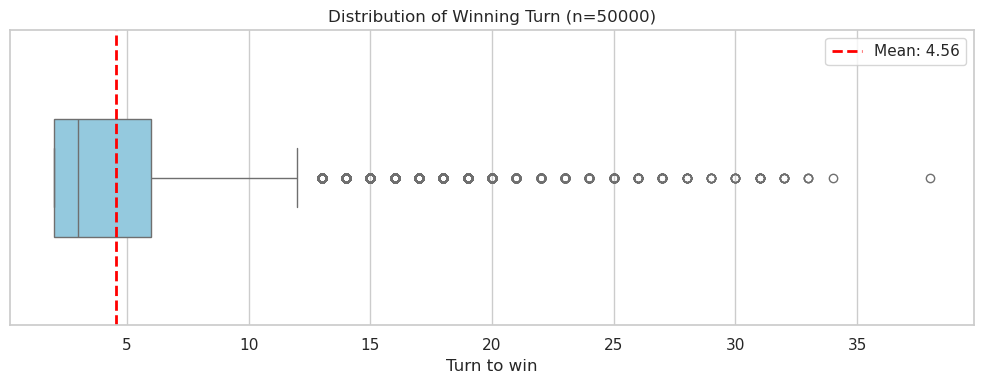

Wins on turn 2: 22165/50000 -> 44.33% of all games


In [254]:
deck_list = {
    "Allosaurus Rider" : 4,
    "Atraxa, Grand Unifier" : 1,
    "Boseiju, Who Endures" : 1,
    "Breeding Pool" : 4,
    "Bridgeworks Battle" : 2,
    "Consign to Memory" : 4,
    "Disciple of Freyalise" : 2,
    "Eldritch Evolution": 4,
    "Endurance": 1,
    "Flooded Strand": 2,
    "Forest": 1,
    "Generous Ent": 2,
    "Ghalta, Stampede Tyrant": 2,
    "Griselbrand": 1,
    "Hedge Maze": 0,
    "Hooting Mandrills": 1, # for now I'll ignore mandrills, I'll implement delve later
    "Island" : 1,
    "Misty Rainforest": 4,
    "Neoform": 4,
    "Pact of Negation" : 4,
    "Planar Genesis": 4,
    "Preordain": 0,
    "Scalding Tarn": 2,
    "Summoner's Pact": 4, # for now we'll just consider pact as additional copies of Rider
    "Veil of Summer": 4,
    "Xenagos, God of Revels": 1
}

win = []
for i in range(50000):
    w = simulate_game_on_play_no_mull(deck_list)
    win.append(w)

win = np.array(win, dtype=float)
average_turn_win = np.mean(win)
median_turn_win = np.median(win)

print(f'This list wins on average on turn : {average_turn_win}, median : {median_turn_win}')

# clean NaNs (games that didn't win)
wins_clean = win[~np.isnan(win)]

plt.figure(figsize=(10, 4))
ax = sns.boxplot(x=wins_clean, color="skyblue", width=0.4)

ax.set_xlabel("Turn to win")
ax.set_title(f"Distribution of Winning Turn (n={len(wins_clean)})")

# annotate mean and median
ax.axvline(average_turn_win, color="red", linestyle="--", linewidth=2, label=f"Mean: {average_turn_win:.2f}")
# ax.axvline(median_turn_win, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_turn_win:.0f}")

ax.legend()
plt.tight_layout()
plt.show()


count_turn2 = int(np.sum(win == 2))
pct_of_all = count_turn2 / win.size * 100
pct_of_wins = count_turn2 / wins_clean.size * 100 if wins_clean.size > 0 else np.nan

print(f"Wins on turn 2: {count_turn2}/{win.size} -> {pct_of_all:.2f}% of all games")